# Explore a VEDB session

The goal of this notebook is to take you through the gaze and world video components of a VEDB session and show pointers for how to use them. If you are interested in head tracking, [this repository](https://github.com/bszek213/head_eye) provides excellent explanations.

Let's start by importing some helpful libraries.

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import glob

The [Databrary repository](https://nyu.databrary.org/volume/1612) contains the video files for each session (worldPrivate.mp4, eye0_blur.mp4 (right eye), and eye1_blur.mp4 (left eye)).

The [OSF repository](https://osf.io/2gdkb/) contains:


*   marker_times.yaml (time stamps for calibration and validation)
*   Time stamps for each data stream (eye0, eye1, world, accelerometer, gyroscope, odometry)
*  [Pupil Labs](https://pupil-labs.com/) data files for each stream.
*  Extrinsics and intrinsics for the world camera (most sessions).
*  Directory of processed gaze files. These contain:
  * Calibration and validation marker locations (calibration_markers.npz and validation_markers.npz, respectively)
  * Pupil locations during calibration (pupil_left_calibrate.npz and pupil_right_calibrate.npz)
  * Pupil locations for entire session (pupil_all.npz)
  * Gaze calibration file (gaze_calibration.npz)
  * Immediate calibration error (error.npz)
  * Validation error (validation_error.npz)
  * Gaze file for session (gaze.npz)

We recommend placing all files into the same directory, named after the session timestamp.

For this tutorial, we have uploaded the relevant files directly to the notebook. The session we are using is:
2023_08_22_17_37_35



In [ ]:
origin = '/content/drive/MyDrive/Research/VEDB/2023_08_22_17_37_35'
os.chdir(origin)

%ls

eye0_blur.mp4        eye1_blur.mp4  eye1_timestamps.npy  processedGaze/  worldPrivate.mp4
eye0_timestamps.npy  eye1.mp4       marker_times.yaml    world.mp4


Note that the eye0.mp4 and eye1.mp4 are released to authorized audiences and world.mp4 is not released to protect the privacy of bystanders.

Let's take a look at a few key frames of the world video:

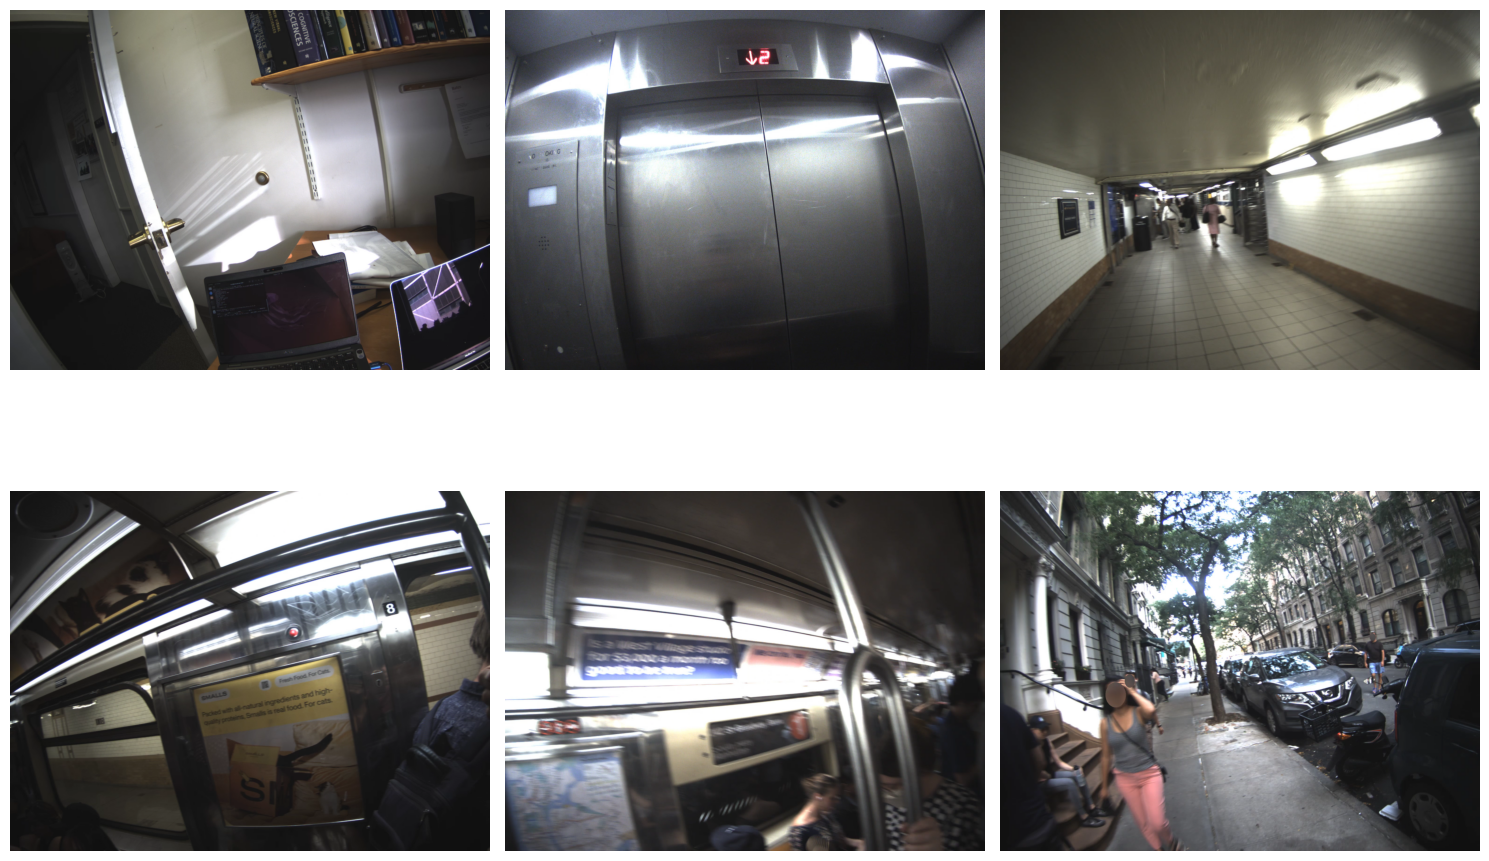

In [ ]:
# Load the video
video_path = os.path.join(origin, 'worldPrivate.mp4')
vid = cv2.VideoCapture(video_path)

# Get video properties
fps = int(vid.get(cv2.CAP_PROP_FPS))
total_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
frame_interval = 5 * 60 * fps  # 5 minutes in frames
num_frames = total_frames // frame_interval

# Initialize a list to store the frames
frames = []

# Capture frames at every 5 minutes
for i in range(num_frames):
    vid.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)
    ret, frame = vid.read()
    if not ret:
        break
    # Convert the frame from BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

vid.release()

# Calculate grid size
grid_size = int(np.ceil(np.sqrt(len(frames))))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))

# Display frames in a grid
for i, frame in enumerate(frames):
    row = i // grid_size
    col = i % grid_size
    axes[row, col].imshow(frame)
    axes[row, col].axis('off')

# Remove empty subplots
for j in range(i + 1, grid_size * grid_size):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

This representation is nice because it tells a bit of a story about the session.

Let's now take a frame from each eye video to ensure that the eyes are properly found in the video frame.

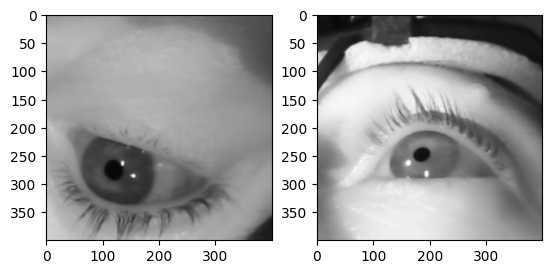

In [9]:
# Load the eye videos
eye0_path = os.path.join(origin, 'eye0_blur.mp4')
eye1_path = os.path.join(origin, 'eye1_blur.mp4')
eye0_vid = cv2.VideoCapture(eye0_path)
eye1_vid = cv2.VideoCapture(eye1_path)

# take a frame about two seconds into the recording
num_frames = 240 # 120 Hz x 2 seconds
for i in range(num_frames):
    ret, frame0 = eye0_vid.read()
    ret, frame1 = eye1_vid.read()

plt.subplot(1,2,1)
plt.imshow(frame0)
plt.subplot(1,2,2)
plt.imshow(frame1)
plt.show()

Everything looks ready to go!

Let's examine the quality of the calibration by first plotting the locations of each detected calibration marker.

In [10]:
# load the calibration markers
cal_mark = np.load(os.path.join(origin, 'processedGaze','calibration_markers.npz'))
print(cal_mark.files)

['location', 'norm_pos', 'size', 'timestamp']


(0.0, 1.0, 1.0, 0.0)

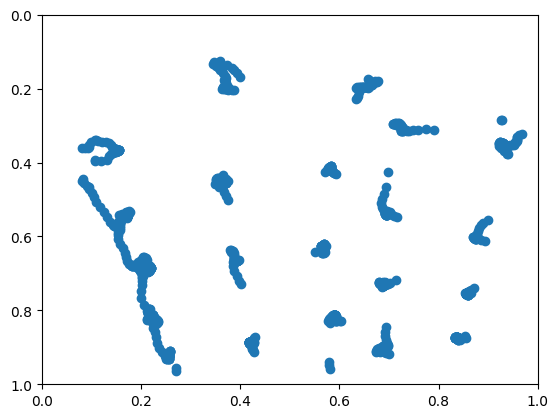

In [11]:
plt.scatter(cal_mark['norm_pos'][:,0], cal_mark['norm_pos'][:,1])
plt.axis([0, 1, 1, 0])

Although we can see a regular grid, we can also see some (likely) spurious detections on the left side. Filtering routines within the [gaze processing pipeline](https://github.com/vedb/vedb-gaze) remove markers that are too brief or are an inappropriate size.

Let's visualize how the computed gaze maps onto this pattern. We will first import a histogram function from the vedb-gaze repo:

In [20]:
# Copied from https://github.com/vedb/vedb-gaze/blob/main/vedb_gaze/visualization.py

def gaze_hist(gaze,
    confidence_threshold=0,
    cmap='gray_r',
    hist_bins_x=81,
    hist_bins_y=61,
    field='norm_pos',
    ax=None):
    """Make a 2D histogram of gaze positions

    Parameters
    ----------
    gaze : dict
        dict of arrays, with at least fields for `field` (kwarg below)
        and 'confidence'
    confidence_threshold : float, optional
        minimum confidence for plotted points, by default 0.0
    cmap : str, optional
        color map for 2D histogram, by default 'gray_r'
    hist_bins_x : int, optional
        number of histogram bins on horizontal (x) axis, by default 81
    hist_bins_y : int, optional
        number of histogram bins on vertical (y) axis, by default 61
    field : str, optional
        name of field within gaze dict to plot, by default 'norm_pos'
        (potentially e.g. 'norm_pos', or 0-1 normalized position by vedb
        naming conventions)
    ax : matplotlib axis, optional
        axis into which to plot histogram, by default None, which creates
        a new figure & axis

    Returns
    -------
    im_handle
        handle for histogram image plotted
    """

    if ax is None:
        fig, ax = plt.subplots()
    # Compute histogram of gaze to show too
    ci = gaze['confidence'] > confidence_threshold
    x, y = gaze[field][ci].T
    im_kw_hist = dict(
        extent=[0, 1, 1, 0],
        aspect='auto',
        cmap=cmap)
    hst = np.histogram2d(y, x, bins=[np.linspace(
        0, 1, hist_bins_y), np.linspace(0, 1, hist_bins_x)], density=True)
    vmax_hst = np.percentile(hst[0], 97.5)
    hst_im = ax.imshow(hst[0], vmax=vmax_hst, **im_kw_hist)
    return hst_im

# utility function to parse npz files as dictionaries
def load_as_dict(path):
    tmp = np.load(path, allow_pickle=True)
    params = {}
    for k, v in tmp.items():
        if isinstance(v, np.ndarray) and (v.dtype==np.dtype("O")):
            if v.shape==():
              params[k] = v.item()
            else:
              params[k] = v
    return params

Now, let's load the gaze file.

In [21]:
calibration_gaze = load_as_dict(os.path.join(origin, 'processedGaze','gaze_calibration.npz'))
print(calibration_gaze.keys())

dict_keys(['left', 'right'])


For convenience, we'll use the right eye.

In [22]:
right_gaze = calibration_gaze['right']

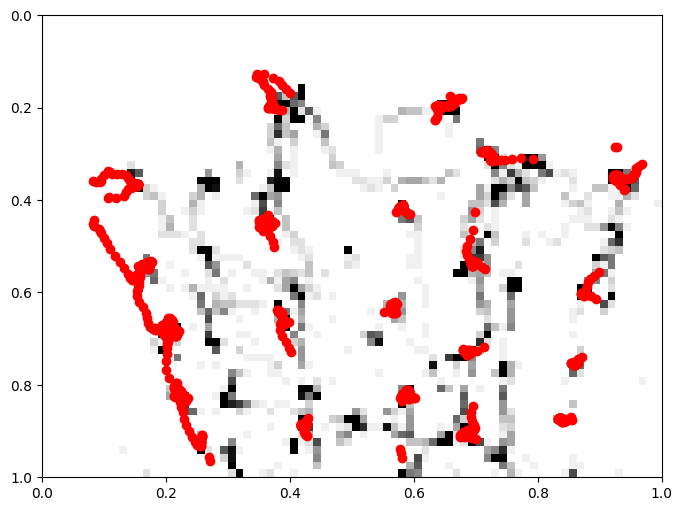

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
# Histogram of estimated gaze
gaze_hist(right_gaze, confidence_threshold=0.6, ax=ax)

# Overlay plot of detected calibration markers
_ = ax.scatter(cal_mark['norm_pos'][:,0],cal_mark['norm_pos'][:,1], c='r')

Here, the calibration markers are plotted in red, and the estimated gaze positions are plotted in black.

A good calibration will show high density of fixations at the location of the marker. In general, this is true for this session, but this visualization demostrates some of the intrinsic noisiness of this type of eyetracking.